In [29]:
import torch
from torch import nn

"""《xPatch: Dual-Stream Time Series Forecasting with Exponential Seasonal-Trend Decomposition》 AAAI 2025
近年来，基于 Transformer 的模型在时间序列预测中的应用受到了广泛关注。尽管 Transformer 架构经常展示出有希望的结果，但由于其注意力机制，它在充分利用时间序列数据中的时间关系方面遇到了挑战。
在这项工作中，我们设计了 eXponential Patch（简称 xPatch），这是一种利用指数分解的新型双流架构。受经典指数平滑方法的启发，xPatch 引入了创新的季节性趋势指数分解模块。
此外，我们提出了一种双流架构，它由基于 MLP 的线性流和基于 CNN 的非线性流组成。该模型研究了在非 Transformer 模型中采用修补和通道独立技术的好处。
最后，我们开发了一个强大的反正切损失函数和一个 S 型学习率调整方案，以防止过度拟合并提高预测性能。
"""
# B站：箫张跋扈 整理并修改(https://space.bilibili.com/478113245)



class EMA(nn.Module):
    """
    Exponential Moving Average (EMA) block to highlight the trend of time series
    """

    def __init__(self, alpha):
        super(EMA, self).__init__()
        # self.alpha = nn.Parameter(alpha)    # Learnable alpha
        self.alpha = alpha

    # Optimized implementation with O(1) time complexity
    def forward(self, x):
        # x: [Batch, Time, Channel]
        _, t, _ = x.shape
        # 1. 计算权重
        powers = torch.flip(torch.arange(t, dtype=torch.double), dims=(0,))
        weights = torch.pow((1 - self.alpha), powers)
        # .to('cuda')

        # 2. 调整权重
        divisor = weights.clone()
        weights[1:] = weights[1:] * self.alpha
        # 3. 计算加权累积和
        weights = weights.reshape(1, t, 1)
        divisor = divisor.reshape(1, t, 1)
        x = torch.cumsum(x * weights, dim=1)
        # 4. 归一化
        x = torch.div(x, divisor)
        return x.to(torch.float32)


# if __name__ == '__main__':
#     # 设置 alpha 的值，例如 0.1
#     alpha = 0.1
#     block = EMA(alpha).to('cuda')

#     # [Batch=2, Time=10, Channel=3]
#     input = torch.rand(2, 10, 3).to('cuda')

#     output = block(input)

#     print("Input size:", input.size())
#     print("Output size:", output.size())

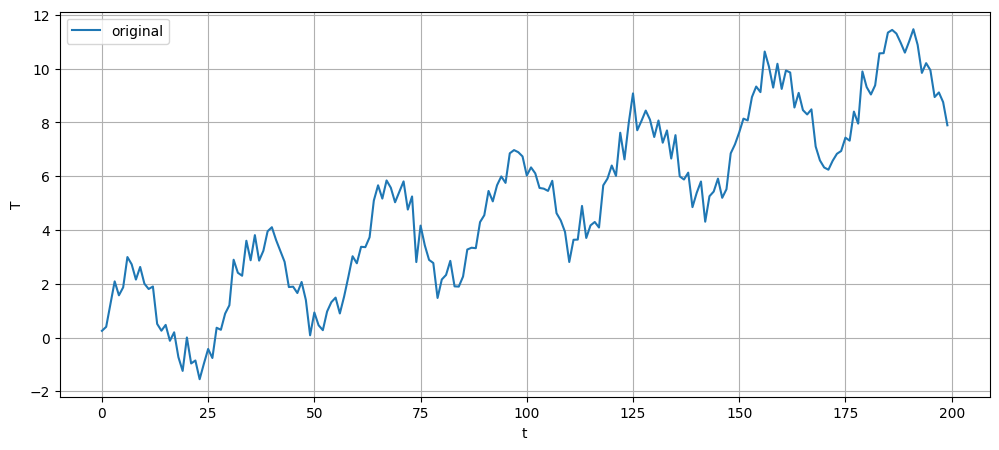

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子确保结果可复现
np.random.seed(42)

# 时间步数
n = 200

# 构造时间序列：线性趋势 + 正弦波周期项 + 高斯噪声
time = np.arange(n)
trend = 0.05 * time  # 线性趋势
seasonal = 2 * np.sin(2 * np.pi * time / 30)  # 周期性项
noise = np.random.normal(0, 0.5, size=n)  # 高斯噪声

# 综合生成序列
series = trend + seasonal + noise

# 可视化原始时间序列
plt.figure(figsize=(12, 5))
plt.plot(time, series, label="original")
# plt.title("模拟温度时间序列（趋势 + 周期 + 噪声）")
plt.xlabel("t")
plt.ylabel("T")
plt.legend()
plt.grid(True)
plt.show()


In [31]:

alpha = 0.1
block = EMA(alpha)

# [Batch=2, Time=10, Channel=3]
input = torch.tensor(series.reshape(1,-1, 1))

output = block(input)

print("Input size:", input.size())
print("Output size:", output.size())

Input size: torch.Size([1, 200, 1])
Output size: torch.Size([1, 200, 1])


In [32]:
output = output.squeeze().detach().numpy()
output.shape

(200,)

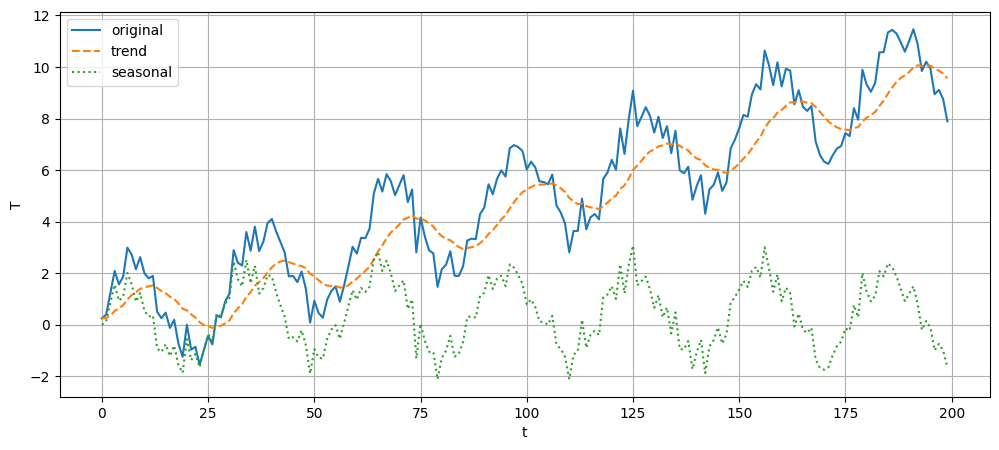

In [33]:

# 可视化原始时间序列
plt.figure(figsize=(12, 5))
plt.plot(time, series, label="original")
plt.plot(time, output, label="trend", linestyle='--')
plt.plot(time, series-output, label="seasonal", linestyle=':')
# plt.title("模拟温度时间序列（趋势 + 周期 + 噪声）")
plt.xlabel("t")
plt.ylabel("T")
plt.legend()
plt.grid(True)
plt.show()